## Install

In [11]:
! pip install torch -f https://download.pytorch.org/whl/torch_stable.html
! pip install pytorch-forecasting
! pip install fastparquet
! pip install python-snappy
! pip install pyarrow 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  ERROR: Command errored out with exit status 1:
   command: /usr/local/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-uyu6gm9x/python-snappy/setup.py'"'"'; __file__='"'"'/tmp/pip-install-uyu6gm9x/python-snappy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-mjd0l2e9
       cwd: /tmp/pip-install-uyu6gm9x/python-snappy/
  Complete output (23 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.7
  creating build/lib.linux-x86_64-3.7/snappy
  copying snappy/snappy.py -> build/lib.linux-x86_64-3.7/snappy
  copying snappy/__init__.py -> build/lib.linux-x86_64-3.7/snappy
  copying snappy/snappy_cffi_builder.py -> build/lib.linux-x86_64-3.7/snappy
  copying snappy/h

## Import

In [9]:
import os
import warnings
warnings.filterwarnings("ignore")

os.chdir("../../..")
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateLogger
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## データの読み込み
まず、時系列をpandasのデータフレームに変換し、各行をタイムステップと時系列で識別できるようにする必要があります。幸いなことに、ほとんどのデータセットはすでにこの形式になっています。このチュートリアルでは、様々な飲料の販売を記述するKaggleからスタリオンデータセットを使用します。我々のタスクは、店舗である代理店によって販売されている商品であるSKU（Stock Keeping Units）別の販売数量の6ヶ月予測を行うことです。月間の過去の販売実績は約21,000件あります。過去の販売実績に加えて、販売価格、代理店の所在地、休日などの特別日、業界全体の販売数量などの情報があります。

このデータセットはすでに正しいフォーマットになっていますが、いくつかの重要な機能を見逃しています。最も重要なのは、各時間ステップごとに1ずつインクリメントされる時間インデックスを追加する必要があることです。さらに、日付機能を追加することは有益です。

In [12]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [13]:
data.describe()


,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


## データセットとデータローダーの作成
次のステップは、データフレームをPyTorch Forecastingデータセットに変換することです。データセットに、どの特徴がカテゴリカルなのか連続的なのか、どの特徴が静的なのか時間的に変化しているのかを伝えることとは別に、データをどのように正規化するかを決定しなければなりません。ここでは、各時系列を個別に標準化し、値が常に正であることを示します。一般的に、正規化によって生じる先読みバイアスを避けるためには、訓練に合わせて各エンコーダシーケンス上で動的にスケーリングするEncoderNormalizerが好まれます。しかし、例えば、データにゼロが多く含まれているなど、合理的に安定した正規化を見つけるのに苦労している場合は、先読みバイアスを許容するかもしれません。あるいは、推論において、より安定した正規化を期待している場合です。後者の場合、推論を実行する際には存在しない「奇妙な」ジャンプを学習しないようにすることで、より現実的なデータセットで学習します。

また、過去6ヶ月間を検証セットとして使用することも選択しています。

In [14]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], coerce_positive=1.0
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## ベースラインモデルの作成
最後に観測されたボリュームを繰り返すだけで、次の6ヶ月を予測するベースラインモデルを評価すると、アウトパフォームしたいシムレベンチマークが得られます。

In [15]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

## 最適な学習率を見つける
トレーニングの前に、PyTorchLightning学習率ファインダーを使用して最適な学習率を特定できます。

In [16]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Number of parameters in network: 29.6k


ネットワーク内のパラメーターの数：29.6k


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | ModuleDict                      | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

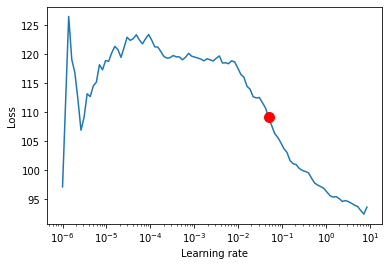

In [17]:
# find optimal learning rate
res = trainer.lr_find(
    tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, max_lr=10., min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [20]:
Temporal Fusion Transformerの場合、最適な学習率は提案されたものよりわずかに低いようです。さらに、PyTorch Lightningは、低い学習率でノイズに混乱することがあり、低すぎる率を示唆することがあるため、提案された学習率を直接使用することは望ましくありません。手動制御は不可欠です。学習率として0.03を選択することにしました。



SyntaxError: invalid syntax (<ipython-input-20-1233b31a906f>, line 1)

## モデルのトレイン
モデルのトレーニングに問題があり、エラーが発生した場合は、tensorflowをアンインストールするか、最初に実行することを検討してくださいAttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

import tensorflow as tf import tensorboard as tb tf.io.gfile = tb.compat.tensorflow_stub.io.gfile。

In [18]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateLogger()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    early_stop_callback=early_stop_callback,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=30,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Number of parameters in network: 29.6k


私のMacbookではトレーニングに約3分かかりますが、大規模なネットワークやデータセットの場合は数時間かかることがあります。ここでは、トレーニング速度は主にオーバーヘッドによって決定され、より大きなbatch_sizeまたはhidden_size（つまりネットワークサイズ）を選択してもトレーニングは直線的に遅くならず、大きなデータセットでのトレーニングが実行可能になります。トレーニング中に、でスピンアップできるテンソルボードを監視できます。たとえば、トレーニングと検証のセットで予測例を監視できます。tensorboard --logdir=lightning_logs

In [19]:
# fit network
trainer.fit(
    tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | ModuleDict                      | 1 K   
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3 K   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8 K   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2 K   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1 K   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1 K   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1 K 

1

In [21]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [22]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(241.8857)

In [23]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

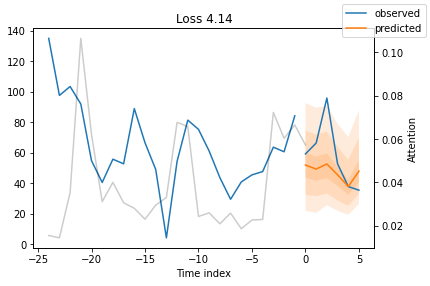

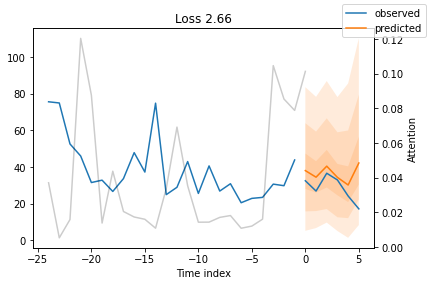

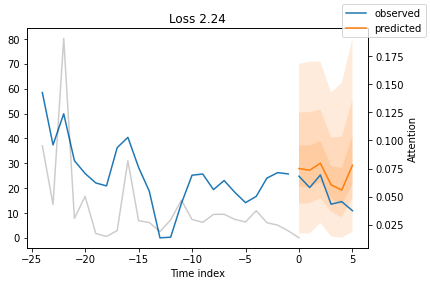

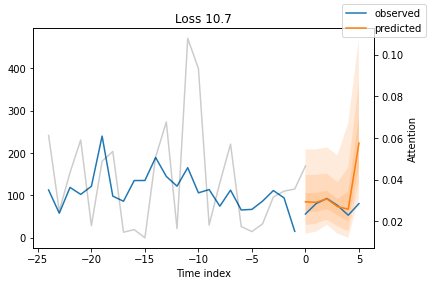

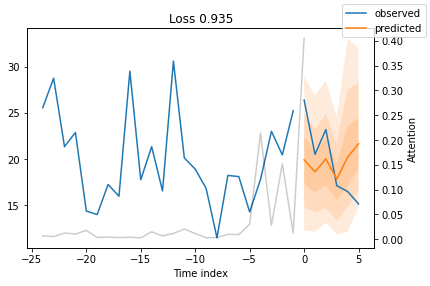

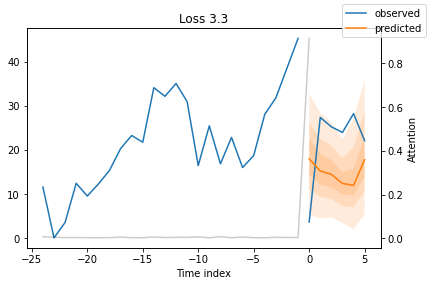

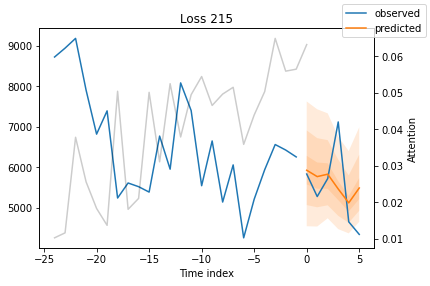

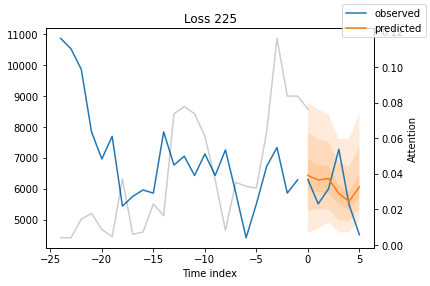

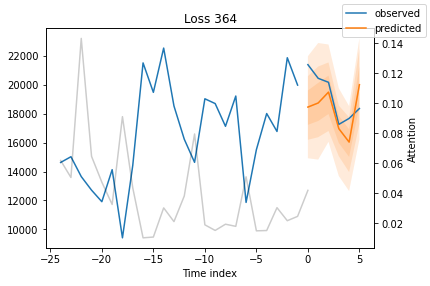

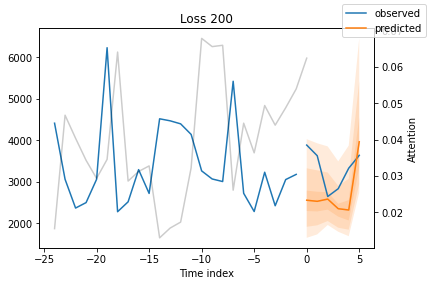

In [24]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

# 悪いモデルのレンダリング

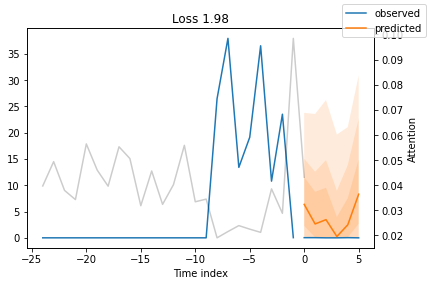

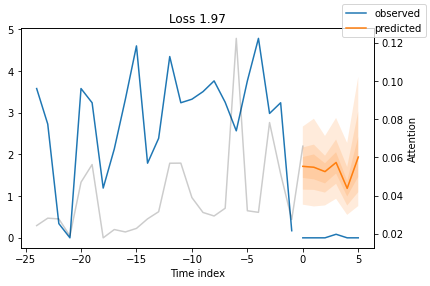

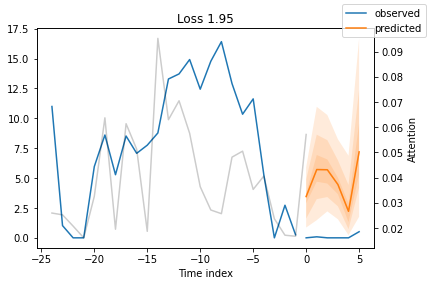

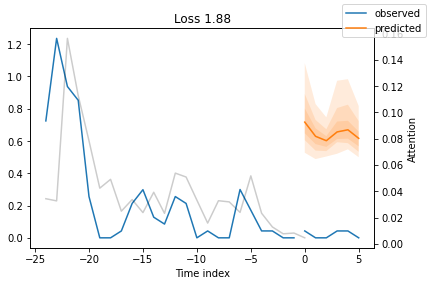

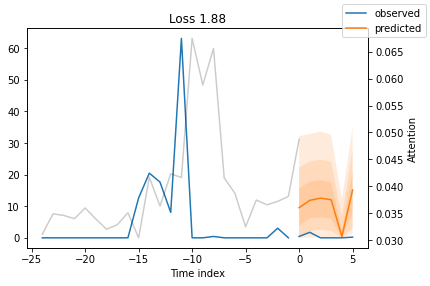

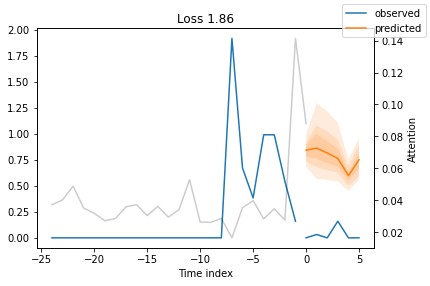

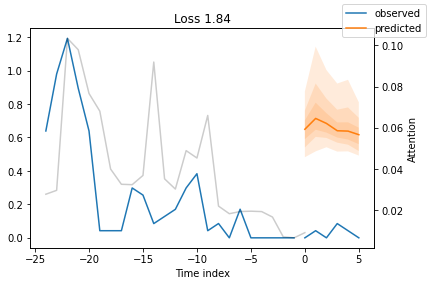

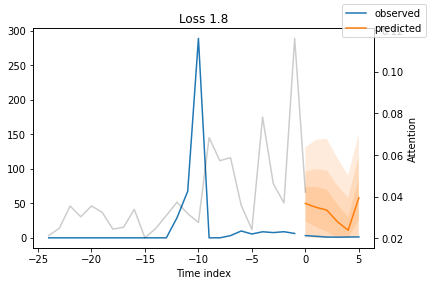

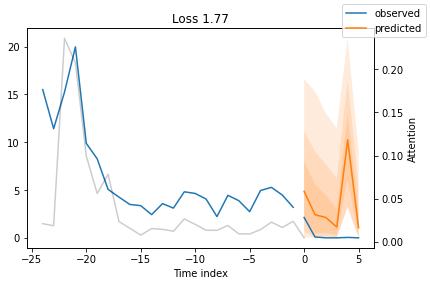

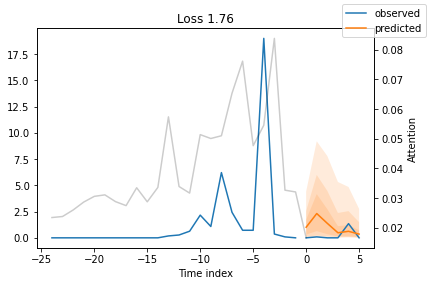

In [25]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10): # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE());


{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

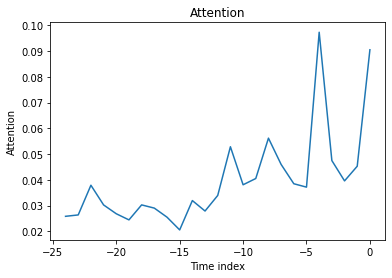

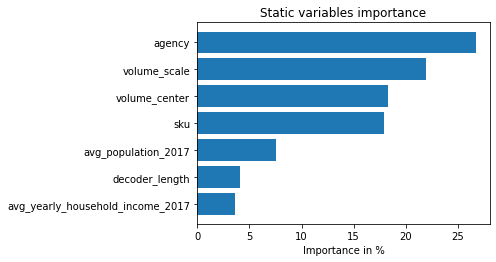

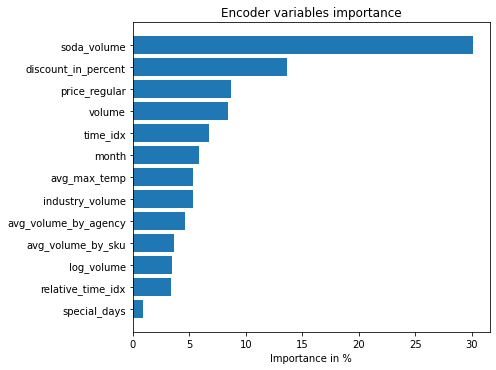

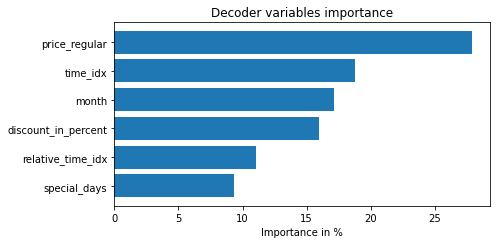

In [26]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [28]:
dependency = best_tft.predict_dependency(val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe")
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(median="median", q25=lambda x: x.quantile(.25),  q75=lambda x: x.quantile(.75))
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=.3);

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html